In [1]:
#https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data/discussion/550839
import pandas as pd
import numpy as np

In [2]:
teams_scores = pd.read_csv("spreadspoke_scores.csv")
#Cleaning the teams_scores

teams_scores = teams_scores[teams_scores['schedule_season'] >= 1979]
teams_scores['weather_detail'] = teams_scores['weather_detail'].fillna('none')
teams_scores['weather_humidity'] = teams_scores['weather_humidity'].fillna(teams_scores['weather_humidity'].median())
teams_scores['weather_wind_mph'] = teams_scores['weather_wind_mph'].fillna(teams_scores['weather_wind_mph'].median())
teams_scores['weather_temperature'] = teams_scores['weather_temperature'].fillna(teams_scores['weather_temperature'].mean())

teams_scores['over_under_line'] = teams_scores['over_under_line'].astype(str).str.strip()
teams_scores['over_under_line'] = teams_scores['over_under_line'].replace('', np.nan)

# Now convert to float
teams_scores['over_under_line'] = teams_scores['over_under_line'].astype(float)

teams_scores = teams_scores.dropna()

# Mapping of old franchise names to new ones
franchise_updates = {
    "Baltimore Colts": "Indianapolis Colts",
    "Boston Patriots": "New England Patriots",
    "Houston Oilers": "Tennessee Titans",
    "Los Angeles Raiders": "Las Vegas Raiders",
    "Oakland Raiders": "Las Vegas Raiders",
    "Pheonix Cardinals": "Arizona Cardinals",
    "San Diego Chargers": "Los Angeles Chargers",
    "St. Louis Cardinals": "Arizona Cardinals",
    "St. Louis Rams": "Los Angeles Rams",
    "Tennessee Oilers": "Tennessee Titans",
    "Washington Redskins": "Washington Commanders",
    "Washington Football Team": "Washington Commanders"
}

# Replace old franchise names with new ones in both columns
teams_scores['team_home'] = teams_scores['team_home'].replace(franchise_updates)
teams_scores['team_away'] = teams_scores['team_away'].replace(franchise_updates)

In [3]:
#1
teams_scores['home_team_wins'] = (teams_scores['score_home'] > teams_scores['score_away']).astype(int)

# #2
# teams = pd.read_csv("nfl_teams.csv")
# teams = teams.drop([2, 4, 14, 21, 29, 31, 33, 36, 37, 39, 42, 43])

# id_to_name = dict(zip(teams['team_id'], teams['team_name']))
# teams_scores['favorite_team'] = teams_scores['team_favorite_id'].map(id_to_name)
# teams_scores['favorite_wins'] = (
#     ((teams_scores['favorite_team'] == teams_scores['team_home']) & (teams_scores['score_home'] > teams_scores['score_away'])) |
#     ((teams_scores['favorite_team'] == teams_scores['team_away']) & (teams_scores['score_away'] > teams_scores['score_home']))
# ).astype(int)

# teams_scores = teams_scores.drop('favorite_team', axis=1)

#3
def compute_team_rolling_averages(df):
    """
    For each row, compute rolling averages (last up to 5 games) for both home and away teams:
    - Points scored
    - Points allowed
    Only includes games that occurred BEFORE the current game.
    """
    df = df.copy()
    df = df.sort_values("schedule_date").reset_index(drop=True)

    # Initialize output columns
    df['home_avg_scored'] = np.nan
    df['home_avg_allowed'] = np.nan
    df['away_avg_scored'] = np.nan
    df['away_avg_allowed'] = np.nan

    # Dict to store past games for each team
    team_history = {}

    for idx, row in df.iterrows():
        home = row['team_home']
        away = row['team_away']
        home_score = row['score_home']
        away_score = row['score_away']

        # Ensure team history entries exist
        if home not in team_history:
            team_history[home] = []
        if away not in team_history:
            team_history[away] = []

        # Look up past games for each team (exclude current game)
        home_past = team_history[home][-5:]
        away_past = team_history[away][-5:]

        # Compute home team rolling averages
        if home_past:
            scored = [g[0] for g in home_past]
            allowed = [g[1] for g in home_past]
            df.at[idx, 'home_avg_scored'] = np.mean(scored)
            df.at[idx, 'home_avg_allowed'] = np.mean(allowed)

        # Compute away team rolling averages
        if away_past:
            scored = [g[0] for g in away_past]
            allowed = [g[1] for g in away_past]
            df.at[idx, 'away_avg_scored'] = np.mean(scored)
            df.at[idx, 'away_avg_allowed'] = np.mean(allowed)

        # After computing, update each team's history
        team_history[home].append((home_score, away_score))
        team_history[away].append((away_score, home_score))

    return df

teams_scores = compute_team_rolling_averages(teams_scores)


#4 + #5
# Ensure the DataFrame is sorted chronologically
teams_scores["schedule_date"] = pd.to_datetime(teams_scores["schedule_date"])
teams_scores = teams_scores.sort_values("schedule_date").reset_index(drop=True)

# Create win/loss result for home and away teams
teams_scores["home_result"] = (teams_scores["score_home"] > teams_scores["score_away"]).astype(int).replace({1: 1, 0: -1})
teams_scores["away_result"] = -teams_scores["home_result"]

# Containers to store the results
home_streaks, away_streaks = [], []
home_last5s, away_last5s = [], []

# Dictionary to track each team's past game results
team_results = {}

# Iterate over rows in order
for idx, row in teams_scores.iterrows():
    home_team = row["team_home"]
    away_team = row["team_away"]
    home_result = row["home_result"]
    away_result = row["away_result"]

    # Get past results for both teams
    home_history = team_results.get(home_team, [])
    away_history = team_results.get(away_team, [])

    # Compute streaks
    def compute_streak(history):
        if not history:
            return None
        streak = 0
        last = history[-1]
        for res in reversed(history):
            if res == last:
                streak += res
            else:
                break
        return streak

    # Compute last5s
    def compute_last5(history):
        if not history:
            return None
        return sum(history[-5:])

    # Append streaks and last5s for this game
    home_streaks.append(compute_streak(home_history))
    away_streaks.append(compute_streak(away_history))
    home_last5s.append(compute_last5(home_history))
    away_last5s.append(compute_last5(away_history))

    # Update team histories AFTER calculating
    team_results.setdefault(home_team, []).append(home_result)
    team_results.setdefault(away_team, []).append(away_result)

# Assign to DataFrame
teams_scores["home_streak"] = home_streaks
teams_scores["away_streak"] = away_streaks
teams_scores["home_last5"] = home_last5s
teams_scores["away_last5"] = away_last5s

teams_scores = teams_scores.drop(['home_result', 'away_result'], axis=1)


#6
def calculate_head_to_head(df):
    head_to_head_results = []

    # Ensure proper sorting
    df = df.sort_values('schedule_date').reset_index(drop=True)

    for idx, row in df.iterrows():
        date = row['schedule_date']
        team_home = row['team_home']
        team_away = row['team_away']

        # Find previous matchups between the same two teams
        past_matchups = df[
            (((df['team_home'] == team_home) & (df['team_away'] == team_away)) |
             ((df['team_home'] == team_away) & (df['team_away'] == team_home))) &
            (df['schedule_date'] < date)
        ].sort_values('schedule_date')

        # Take up to the last 5 games
        past_matchups = past_matchups.tail(5)

        score = 0
        for _, match in past_matchups.iterrows():
            # Determine who won the past game
            if match['score_home'] > match['score_away']:
                winner = match['team_home']
            elif match['score_home'] < match['score_away']:
                winner = match['team_away']
            else:
                continue  # Tie or draw — skip, or you could count as 0

            # If the current home team was the winner, +1
            if winner == team_home:
                score += 1
            elif winner == team_away:
                score -= 1
            # else: one of the teams is different (edge case — skip)

        head_to_head_results.append(score)

    return head_to_head_results

# Add the new column
teams_scores['head_to_head'] = calculate_head_to_head(teams_scores)

# Convert dates to datetime
teams_scores['schedule_date'] = pd.to_datetime(teams_scores['schedule_date'])

def get_rest_days(df, team_col):
    rest = []

    for team in df[team_col].unique():
        team_df = df[(df['team_home'] == team) | (df['team_away'] == team)].copy()
        team_df = team_df.sort_values('schedule_date')
        team_df['last_game'] = team_df['schedule_date'].shift()
        team_df['rest_days'] = (team_df['schedule_date'] - team_df['last_game']).dt.days
        team_df['team'] = team
        rest.append(team_df[['schedule_date', 'rest_days', 'team']])

    return pd.concat(rest)

home_rest = get_rest_days(teams_scores, 'team_home')
away_rest = get_rest_days(teams_scores, 'team_away')

teams_scores = teams_scores.merge(
    home_rest.rename(columns={'rest_days': 'home_rest_days'}),
    left_on=['team_home', 'schedule_date'],
    right_on=['team', 'schedule_date'],
    how='left'
)

teams_scores = teams_scores.merge(
    away_rest.rename(columns={'rest_days': 'away_rest_days'}),
    left_on=['team_away', 'schedule_date'],
    right_on=['team', 'schedule_date'],
    how='left'
)

teams_scores.drop(columns=['team_x', 'team_y'], inplace=True)





In [4]:
teams = pd.read_csv("nfl_teams.csv")
teams = teams.drop([2,4, 14,21, 29, 31, 33, 36, 37, 39, 42, 43])

START_ELO = 1000

def margin_multiplier(margin):
    return 1 + min(margin, 30) / 30

# Initialize Elo structures
elo_dict = {
    'general': {}, 'home': {}, 'away': {}, 'playoff': {},
    'recent': {}, 'favorite': {}, 'underdog': {}, 'bad_weather': {}
}
recent_games = {}

# Add team IDs
teams_scores['home_team_id'] = teams_scores['team_home'].map(
    teams.set_index('team_name')['team_id']
)
teams_scores['away_team_id'] = teams_scores['team_away'].map(
    teams.set_index('team_name')['team_id']
)

# Drop indoor elos (not using them anymore)
elo_columns = [
    'home_elo', 'away_elo',
    'home_home_elo', 'home_away_elo', 'away_home_elo', 'away_away_elo',
    'home_playoff_elo', 'away_playoff_elo',
    'home_recent_elo', 'away_recent_elo',
    'home_favorite_elo', 'home_underdog_elo', 'away_favorite_elo', 'away_underdog_elo',
    'home_bad_weather_elo', 'away_bad_weather_elo'
]
for col in elo_columns:
    teams_scores[col] = np.nan

last_reset_year = None

for idx, row in teams_scores.iterrows():
    year = row['schedule_season']
    home_team = row['home_team_id']
    away_team = row['away_team_id']
    home_score = row['score_home']
    away_score = row['score_away']
    favorite_id = row['team_favorite_id']
    week = row['schedule_week']
    weather = row['weather_detail']
    is_playoff = not str(week).isdigit()
    is_bad_weather = weather not in ['Indoor', 'None', np.nan, None]

    # Reset Elo every 3 years
    if last_reset_year is None or (year - last_reset_year >= 3):
        for d in elo_dict:
            for team in set(teams_scores['home_team_id']).union(set(teams_scores['away_team_id'])):
                elo_dict[d][team] = START_ELO
        recent_games = {team: [] for team in elo_dict['general'].keys()}
        last_reset_year = year

    # Ensure teams are initialized
    for d in elo_dict:
        for team in [home_team, away_team]:
            if team not in elo_dict[d]:
                elo_dict[d][team] = START_ELO
    for team in [home_team, away_team]:
        if team not in recent_games:
            recent_games[team] = []

    elos = {
        'home': {
            'general': elo_dict['general'][home_team],
            'home': elo_dict['home'][home_team],
            'away': elo_dict['away'][home_team],
            'playoff': elo_dict['playoff'][home_team],
            'recent': elo_dict['recent'][home_team],
            'favorite': elo_dict['favorite'][home_team],
            'underdog': elo_dict['underdog'][home_team],
            'bad_weather': elo_dict['bad_weather'][home_team],
        },
        'away': {
            'general': elo_dict['general'][away_team],
            'home': elo_dict['home'][away_team],
            'away': elo_dict['away'][away_team],
            'playoff': elo_dict['playoff'][away_team],
            'recent': elo_dict['recent'][away_team],
            'favorite': elo_dict['favorite'][away_team],
            'underdog': elo_dict['underdog'][away_team],
            'bad_weather': elo_dict['bad_weather'][away_team],
        }
    }

    # Assign Elos to DataFrame
    teams_scores.at[idx, 'home_elo'] = elos['home']['general']
    teams_scores.at[idx, 'away_elo'] = elos['away']['general']

    teams_scores.at[idx, 'home_home_elo'] = elos['home']['home']
    teams_scores.at[idx, 'home_away_elo'] = elos['home']['away']
    teams_scores.at[idx, 'away_home_elo'] = elos['away']['home']
    teams_scores.at[idx, 'away_away_elo'] = elos['away']['away']

    teams_scores.at[idx, 'home_playoff_elo'] = elos['home']['playoff']
    teams_scores.at[idx, 'away_playoff_elo'] = elos['away']['playoff']

    teams_scores.at[idx, 'home_recent_elo'] = elos['home']['recent']
    teams_scores.at[idx, 'away_recent_elo'] = elos['away']['recent']

    teams_scores.at[idx, 'home_favorite_elo'] = elos['home']['favorite']
    teams_scores.at[idx, 'home_underdog_elo'] = elos['home']['underdog']
    teams_scores.at[idx, 'away_favorite_elo'] = elos['away']['favorite']
    teams_scores.at[idx, 'away_underdog_elo'] = elos['away']['underdog']

    teams_scores.at[idx, 'home_bad_weather_elo'] = elos['home']['bad_weather']
    teams_scores.at[idx, 'away_bad_weather_elo'] = elos['away']['bad_weather']

    # Skip if no score
    if pd.isna(home_score) or pd.isna(away_score):
        continue

    if home_score > away_score:
        winner, loser = home_team, away_team
        home_result, away_result = 1, 0
    elif home_score < away_score:
        winner, loser = away_team, home_team
        home_result, away_result = 0, 1
    else:
        continue  # skip ties

    margin = abs(home_score - away_score)
    multiplier = margin_multiplier(margin)
    base_change = 50

    home_elo = elos['home']['general']
    away_elo = elos['away']['general']

    expected_home = 1 / (1 + 10 ** ((away_elo - home_elo) / 400))
    expected_away = 1 - expected_home

    home_change = base_change * (home_result - expected_home) * multiplier
    away_change = base_change * (away_result - expected_away) * multiplier

    # Update Elo for each category
    elo_dict['general'][home_team] += home_change
    elo_dict['general'][away_team] += away_change

    elo_dict['home'][home_team] += home_change
    elo_dict['away'][away_team] += away_change

    if is_playoff:
        elo_dict['playoff'][home_team] += home_change
        elo_dict['playoff'][away_team] += away_change

    if is_bad_weather:
        elo_dict['bad_weather'][home_team] += home_change
        elo_dict['bad_weather'][away_team] += away_change

    if favorite_id == home_team:
        elo_dict['favorite'][home_team] += home_change
        elo_dict['underdog'][away_team] += away_change
    elif favorite_id == away_team:
        elo_dict['favorite'][away_team] += away_change
        elo_dict['underdog'][home_team] += home_change

    # Recent Elo (rolling 10 games)
    for team, change in [(home_team, home_change), (away_team, away_change)]:
        recent_games[team].append(change)
        if len(recent_games[team]) > 10:
            recent_games[team].pop(0)
        elo_dict['recent'][team] = START_ELO + sum(recent_games[team])

In [5]:
# Map full team names to team IDs using the 'teams' DataFrame
team_name_to_id = teams.set_index('team_name')['team_id'].to_dict()

# Create a new column that maps each home team to its team_id
teams_scores['home_team_id'] = teams_scores['team_home'].map(team_name_to_id)

# Generate 'home_is_favorite' with logic for PICK
def determine_home_favorite(row):
    if row['team_favorite_id'] == 'PICK':
        return -1
    return 1 if row['team_favorite_id'] == row['home_team_id'] else 0

# Create temporary column
teams_scores['home_is_favorite'] = teams_scores.apply(determine_home_favorite, axis=1)

# Replace 'team_favorite_id' with 'home_is_favorite'
favorite_idx = teams_scores.columns.get_loc('team_favorite_id')
teams_scores.drop(columns=['team_favorite_id'], inplace=True)
cols = list(teams_scores.columns)
# Move 'home_is_favorite' into the original 'team_favorite_id' position
cols.insert(favorite_idx, cols.pop(cols.index('home_is_favorite')))
teams_scores = teams_scores[cols]

# Clean up
teams_scores.drop(columns=['home_team_id'], inplace=True)

# Ensure binary columns are integers
teams_scores['schedule_playoff'] = teams_scores['schedule_playoff'].astype(int)
teams_scores['stadium_neutral'] = teams_scores['stadium_neutral'].astype(int)

# Clean and standardize playoff round labels
playoff_week_mapping = {
    "wildcard": 19,
    "division": 20,
    "conference": 21,
    "superbowl": 22,
    "super bowl": 22
}

def convert_week_to_numeric(x):
    try:
        return int(x)
    except:
        key = str(x).strip().lower()
        return playoff_week_mapping.get(key, None)

teams_scores['schedule_week'] = teams_scores['schedule_week'].apply(convert_week_to_numeric)

# Drop unused columns if they exist
teams_scores.drop(columns=['away_team_id', 'stadium'], errors='ignore', inplace=True)

# Add a column 'is_weekend': 1 if Saturday or Sunday, else 0
teams_scores['is_weekend'] = teams_scores['schedule_date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# Drop the original 'schedule_date' column
teams_scores = teams_scores.drop(columns=['schedule_date'])

# One-hot encode team_home, team_away, and weather_detail
one_hot_encoded = pd.get_dummies(teams_scores[['team_home', 'team_away', 'weather_detail']],
                                  prefix=['home', 'away', 'weather'])

# Drop original columns
teams_scores = teams_scores.drop(columns=['team_home', 'team_away', 'weather_detail'])

# Concatenate one-hot encoded columns
teams_scores = pd.concat([teams_scores, one_hot_encoded], axis=1)

# Convert all boolean columns (True/False) to integers (1/0)
bool_cols = teams_scores.select_dtypes(include=['bool']).columns
teams_scores[bool_cols] = teams_scores[bool_cols].astype(int)

teams_scores = teams_scores.dropna()

In [6]:
######################################################33
#Classification Model start

[0]	train-logloss:0.69218	eval-logloss:0.69219
[1]	train-logloss:0.69119	eval-logloss:0.69120
[2]	train-logloss:0.69023	eval-logloss:0.69021
[3]	train-logloss:0.68931	eval-logloss:0.68925
[4]	train-logloss:0.68838	eval-logloss:0.68832
[5]	train-logloss:0.68745	eval-logloss:0.68738
[6]	train-logloss:0.68653	eval-logloss:0.68644
[7]	train-logloss:0.68568	eval-logloss:0.68556
[8]	train-logloss:0.68481	eval-logloss:0.68466
[9]	train-logloss:0.68400	eval-logloss:0.68384
[10]	train-logloss:0.68318	eval-logloss:0.68304
[11]	train-logloss:0.68237	eval-logloss:0.68223
[12]	train-logloss:0.68158	eval-logloss:0.68141
[13]	train-logloss:0.68078	eval-logloss:0.68062
[14]	train-logloss:0.68001	eval-logloss:0.67988
[15]	train-logloss:0.67921	eval-logloss:0.67908
[16]	train-logloss:0.67846	eval-logloss:0.67832
[17]	train-logloss:0.67772	eval-logloss:0.67755
[18]	train-logloss:0.67701	eval-logloss:0.67683
[19]	train-logloss:0.67632	eval-logloss:0.67614
[20]	train-logloss:0.67565	eval-logloss:0.67545
[2

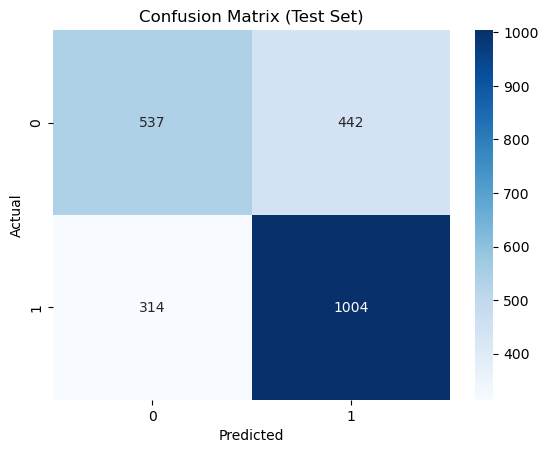

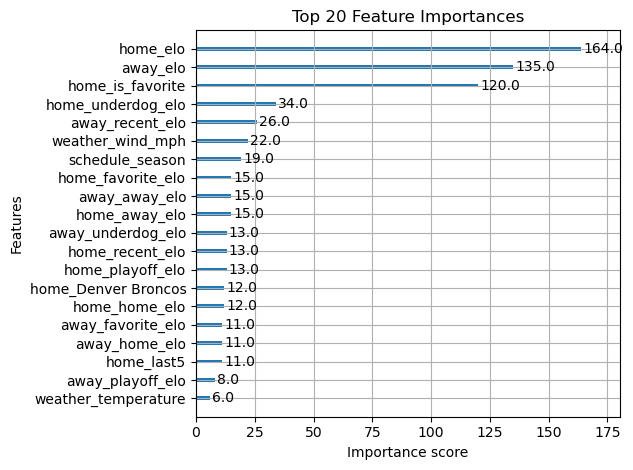

In [7]:
!pip install xgboost

teams_scores_classification = teams_scores.drop(columns=['spread_favorite', 'over_under_line', 'score_home', 'score_away'])
#XGBoost Model start

# === 1. Imports ===
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === 2. Prepare data ===
y = teams_scores_classification['home_team_wins']
X = teams_scores_classification.drop(columns=['home_team_wins'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# === 3. Set parameters ===
#Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.75}
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.01,
    'subsample': 0.75,
    'colsample_bytree': 1.0,
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight
}

# === 4. Train with early stopping ===
evallist = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=evallist,
    early_stopping_rounds=10,
    verbose_eval=True
)

# === 5. Predict and evaluate ===

# Predict on test set
y_pred_prob_test = model.predict(dtest)
y_pred_test = np.where(y_pred_prob_test > 0.5, 1, 0)

# Predict on train set
y_pred_prob_train = model.predict(dtrain)
y_pred_train = np.where(y_pred_prob_train > 0.5, 1, 0)

# Print accuracy on both
print("Training Accuracy:", round(accuracy_score(y_train, y_pred_train), 4))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_test), 4))

# Classification report (test set)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

# Confusion matrix (test set)
conf_mat = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === 6. Feature importance ===
xgb.plot_importance(model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()
#Test 65.61%
#Predicted 67.09% Accuracy 

In [8]:
######################################################33
#Regression Model start

C:\Users\amuel\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\amuel\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Home Team Score Prediction:
RMSE: 10.05
MAE: 8.01

Away Team Score Prediction:
RMSE: 9.51
MAE: 7.60


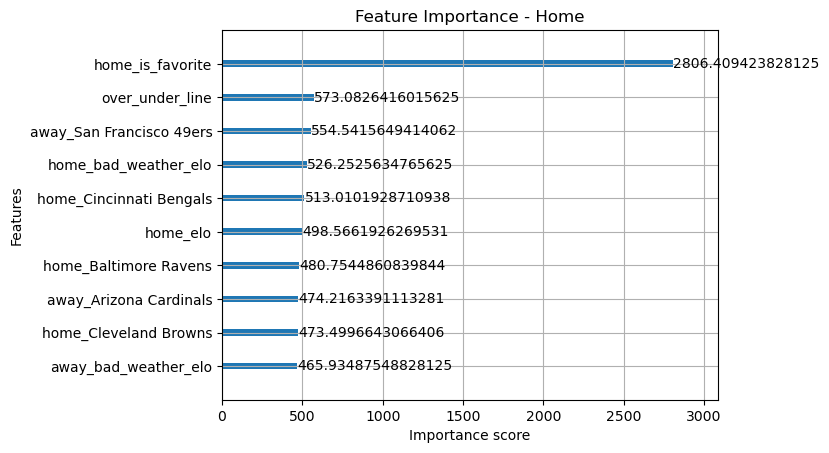

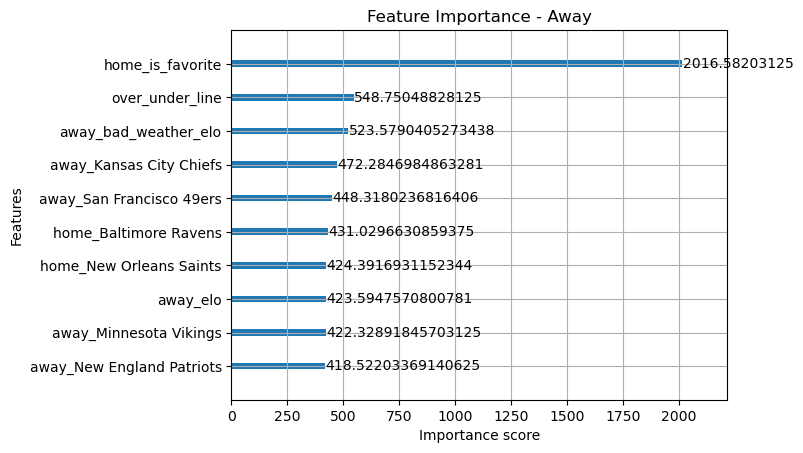

In [9]:
from sklearn.preprocessing import StandardScaler
teams_scores_regression = teams_scores.drop(columns=['home_team_wins'])

# === 1. Separate features and target ===
target_columns = ['score_home', 'score_away']  # adjust if needed
features = teams_scores_regression.drop(columns=target_columns)
targets = teams_scores_regression[target_columns]

# === 2. Scale features ===
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# === 3. Rebuild full scaled DataFrame ===
import pandas as pd
scaled_df = pd.DataFrame(scaled_features, columns=features.columns, index=teams_scores.index)

# === 4. Add target columns back ===
scaled_teams_scores = pd.concat([scaled_df, targets], axis=1)

# === 1. Imports ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

# === 2. Prepare Data ===
# Target variables (regression)
y_home = scaled_teams_scores['score_home']
y_away = scaled_teams_scores['score_away']

# Drop the target columns from features
X = scaled_teams_scores.drop(columns=['score_home', 'score_away'])

# Single train-test split (for both targets at once)
X_train, X_test, y_train_full, y_test_full = train_test_split(
    X, targets, test_size=0.2, random_state=42
)

# Separate individual target columns
y_home_train = y_train_full['score_home']
y_home_test = y_test_full['score_home']
y_away_train = y_train_full['score_away']
y_away_test = y_test_full['score_away']


# === 3. Initialize Models ===
#{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.7}
home_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.01,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42
)

#{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.7}
away_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.01,
    subsample=0.7,
    colsample_bytree=0.5,
    random_state=42
)

# === 4. Train Models ===
home_model.fit(X_train, y_home_train)
away_model.fit(X_train, y_away_train)

# === 5. Predict ===
y_home_pred = home_model.predict(X_test)
y_away_pred = away_model.predict(X_test)

# === 6. Evaluate ===
def evaluate_regression(y_true, y_pred, label):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{label} Score Prediction:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

evaluate_regression(y_home_test, y_home_pred, "Home Team")
evaluate_regression(y_away_test, y_away_pred, "Away Team")

'''
Home Team Score Prediction:
RMSE: 10.05
MAE: 8.01

Away Team Score Prediction:
RMSE: 9.51
MAE: 7.60
'''
# Plot feature importances for home model
xgb.plot_importance(home_model, max_num_features=10, importance_type='gain', title='Feature Importance - Home')
plt.show()

# Plot feature importances for away model
xgb.plot_importance(away_model, max_num_features=10, importance_type='gain', title='Feature Importance - Away')
plt.show()


In [10]:
######################################################33
#Retrain using all data without test split

In [11]:
# === Retrain Classification Model on All Data ===
from xgboost import DMatrix, train

# Use full data
X_full_class = teams_scores_classification.drop(columns=['home_team_wins'])
y_full_class = teams_scores_classification['home_team_wins']

# Handle class imbalance on full set
scale_pos_weight_full = len(y_full_class[y_full_class == 0]) / len(y_full_class[y_full_class == 1])

# DMatrix for full data
dfull = DMatrix(X_full_class, label=y_full_class)

# Same parameters as before
params_full = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.01,
    'subsample': 0.75,
    'colsample_bytree': 1.0,
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight_full
}

# Train final classification model
final_class_model = train(
    params=params_full,
    dtrain=dfull,
    num_boost_round=100
)

print("✅ Final classification model trained on full dataset.")


✅ Final classification model trained on full dataset.


In [12]:
# === Retrain Regression Models on All Data ===

# Features and targets already prepared earlier
X_full_reg = scaled_teams_scores.drop(columns=['score_home', 'score_away'])
y_home_full = scaled_teams_scores['score_home']
y_away_full = scaled_teams_scores['score_away']

# Re-initialize with best parameters
final_home_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.01,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42
)

final_away_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.01,
    subsample=0.7,
    colsample_bytree=0.5,
    random_state=42
)

# Train on full dataset
final_home_model.fit(X_full_reg, y_home_full)
final_away_model.fit(X_full_reg, y_away_full)

print("✅ Final regression models trained on full dataset.")


✅ Final regression models trained on full dataset.


In [13]:
########################## Final ##########################